In [1]:
import math
import datetime as dt
import numpy as np
import pandas
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import SVC

In [2]:
url = "https://drive.google.com/uc?id=1FUsCP40FaphvjFCpfINRVby1eWQRb2oU"
dataset = pd.read_excel(url)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Thông tin chi tiết về  dữ liệu

In [3]:
dataset.shape

(541909, 8)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Dữ liệu bị mất

<Axes: >

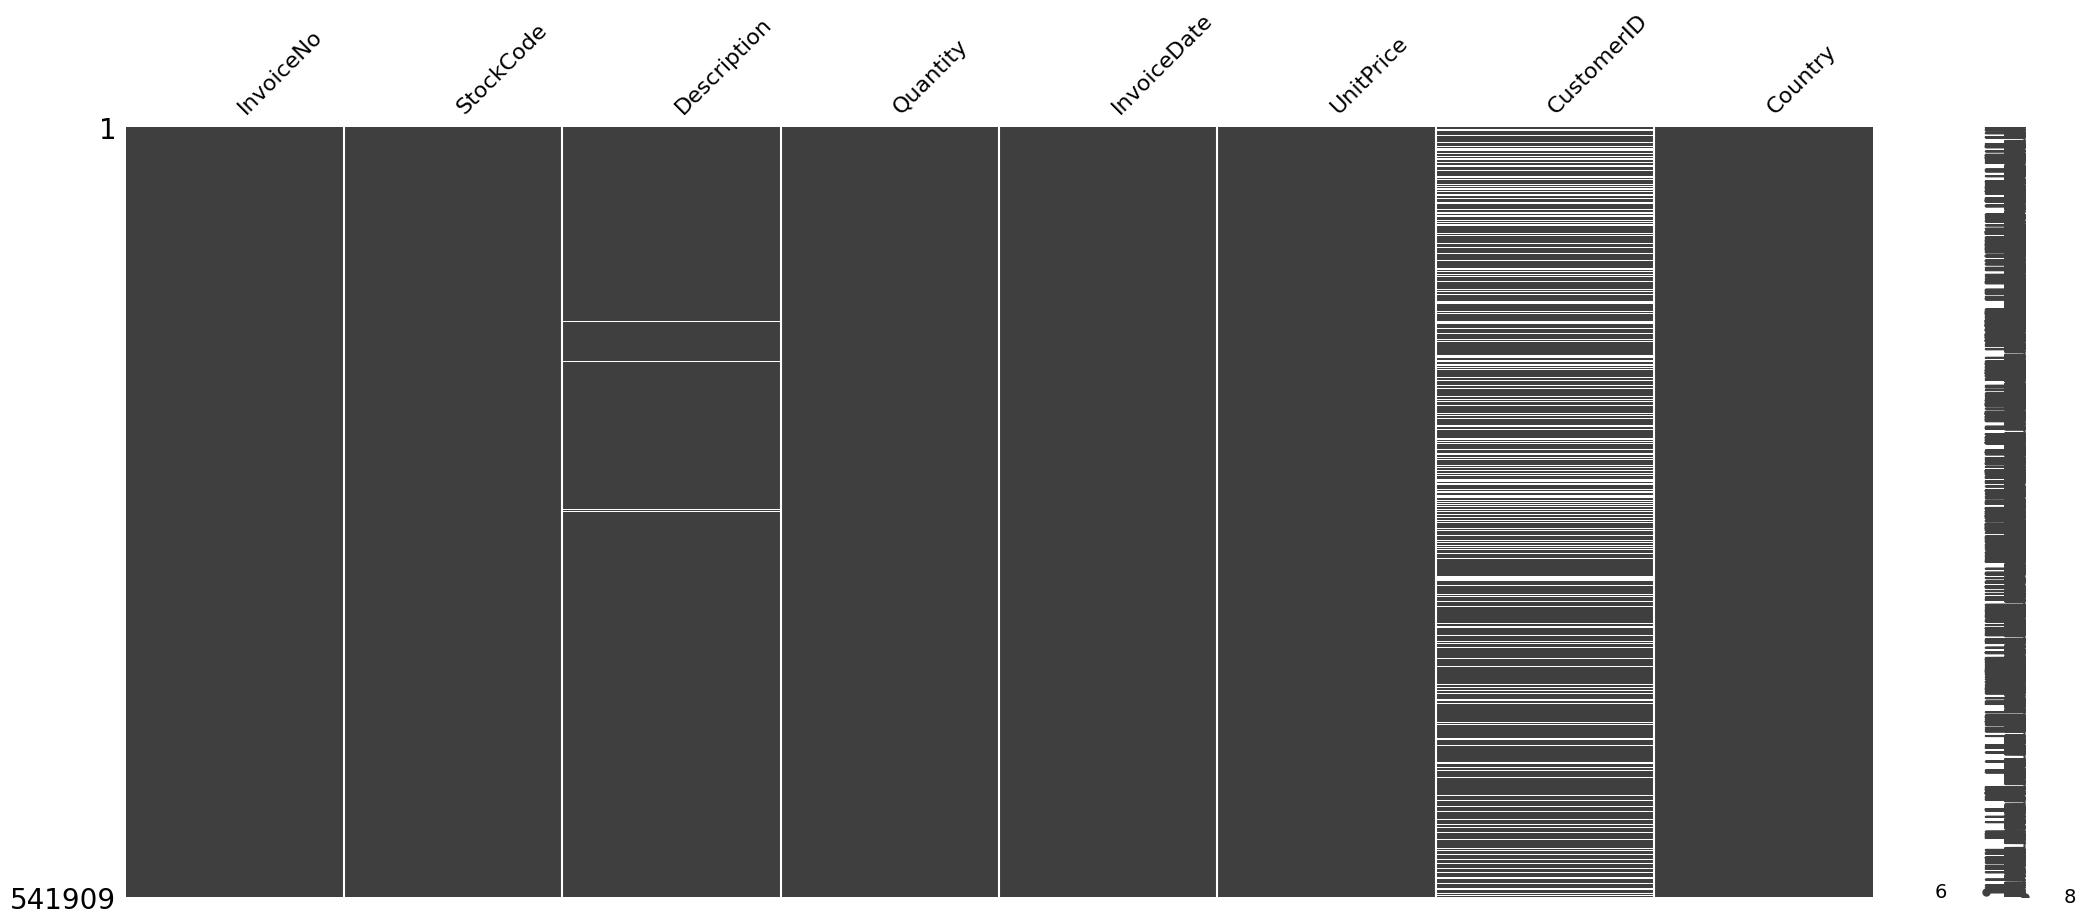

In [5]:
msno.matrix(dataset)

# Xử lý dữ liệu

In [6]:
# Lọc xóa các dữ liệu có thuộc tính bị mất
dataset=dataset.loc[pd.isnull(dataset.CustomerID) == False] # Lọc các hàng có giá trị null

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


<Axes: >

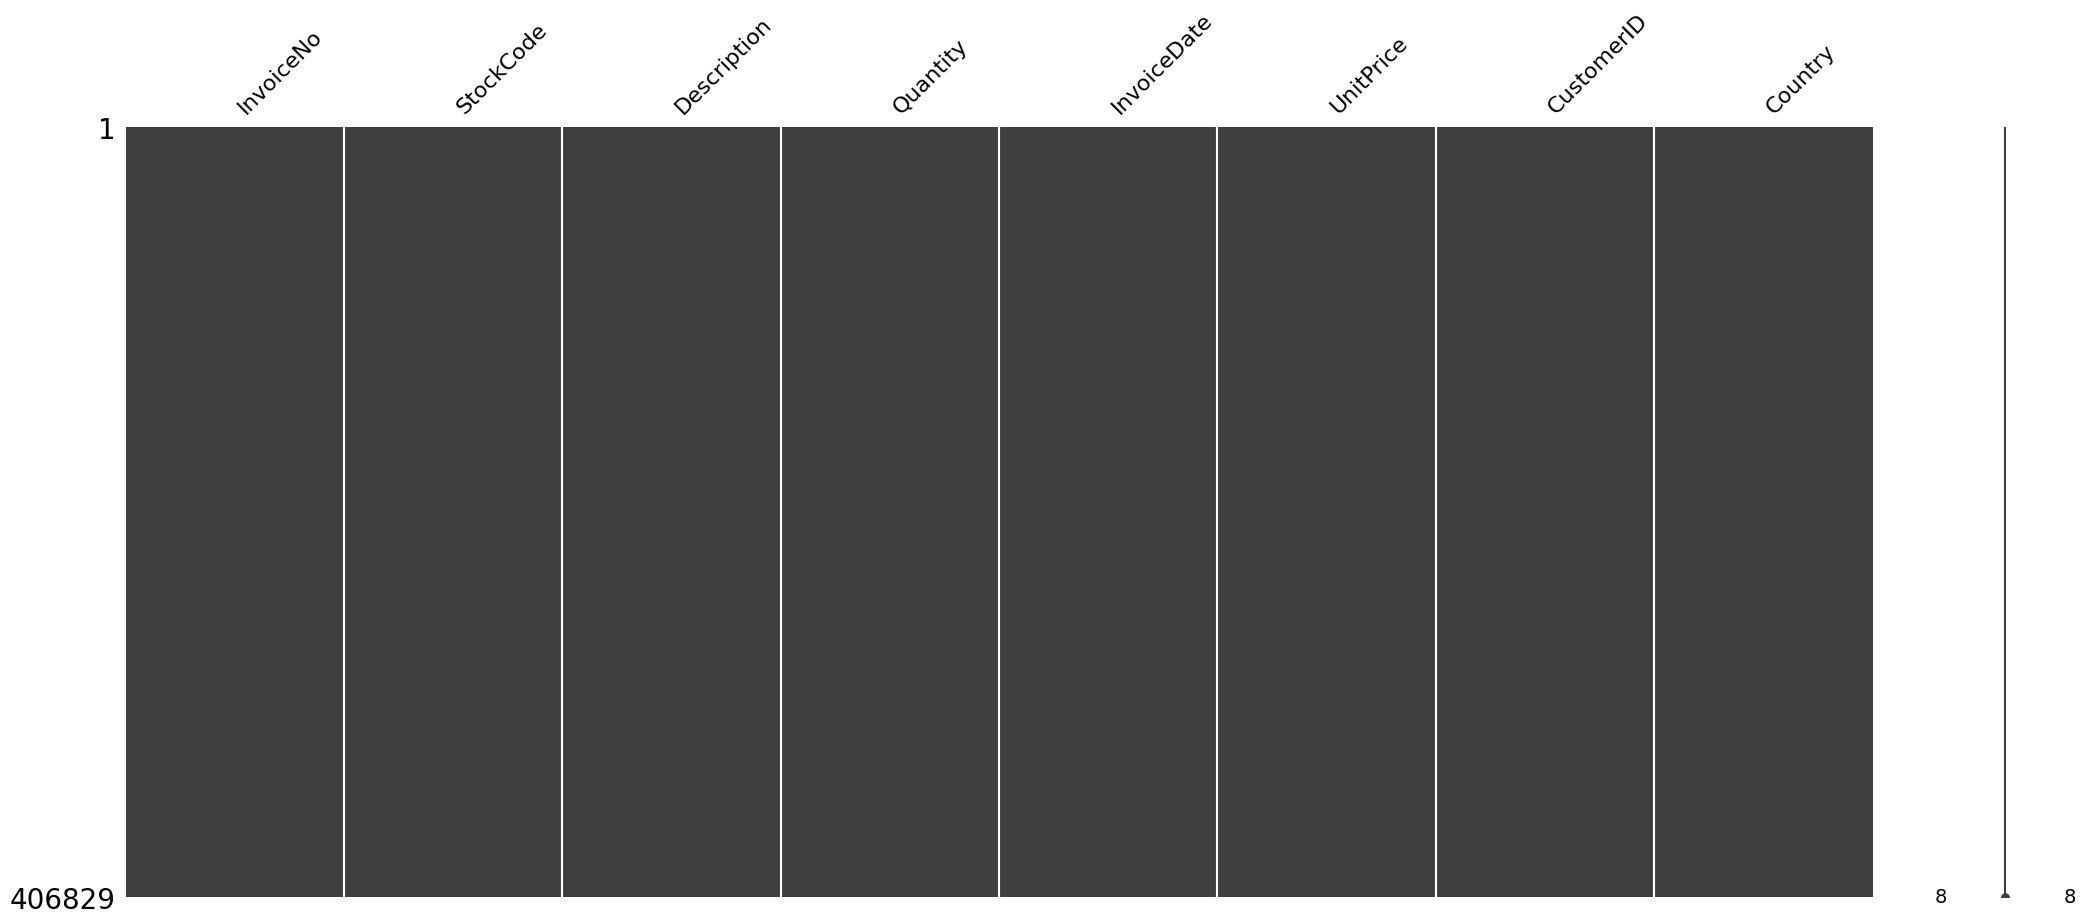

In [8]:
msno.matrix(dataset)

In [9]:
# Mô tả chi tiết toàn bộ DataFrame
dataset.describe(include='all', datetime_is_numeric=True)

TypeError: NDFrame.describe() got an unexpected keyword argument 'datetime_is_numeric'

In [10]:
#Loại bỏ các hàng có Quantity < 0
dataset=dataset[dataset['Quantity']>0]

In [11]:
#Loại bỏ các hàng mà  cột Customer có giá trị là NaN
dataset.dropna(subset=['CustomerID'],how='all',inplace=True)

In [12]:
dataset.shape

(397924, 8)

In [13]:
#Khám phá các giá trị duy nhất của mỗi thuộc tính
print("Số lượng giao dịch: ", dataset['InvoiceNo'].nunique())
print("Số sản phẩm đã mua: ",dataset['StockCode'].nunique())
print("Số lượng khách hàng:", dataset['CustomerID'].nunique() )
print("Tỉ lệ khách hàng NaN: ", round(dataset['CustomerID'].isnull().sum() * 100 / len(dataset),2),"%" )

Số lượng giao dịch:  18536
Số sản phẩm đã mua:  3665
Số lượng khách hàng: 4339
Tỉ lệ khách hàng NaN:  0.0 %


# Xây dựng mô hình RFM

- RECENCY (R): Số ngày kể từ lần mua cuối cùng
- FREQUENCY (F): Tổng số lần mua hàng
- MONETARY VALUE (M): Tổng số tiền khách hàng này đã chi tiêu.

## Recency
* Để tính toán lần mua gần đây cần chọn một ngày làm mốc mà từ đó đánh giá được lần mua hàng gần đây nhất của khách hàng là bao nhiêu ngày.

In [14]:
# Thời gian cuối cùng trong dataset
dataset['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [15]:
now = dt.date(2011,12,10)
print(now)

2011-12-10


In [16]:
#Tạo 1 cột mới có tên là “date” chỉ chứa duy nhất ngày lập hóa đơn
dataset['date'] = dataset['InvoiceDate'].dt.date

In [17]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


#### Recency dataset

In [18]:
# Nhóm theo khách hàng và kiểm tra ngày mua hàng cuối cùng sau đó lưu vào cột "LastPurshaceDate"
recency_data = dataset.groupby(by='CustomerID', as_index=False)['date'].max()
recency_data.columns = ['CustomerID','LastPurshaceDate']
recency_data.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [19]:
#Tính toán số ngày mua gần đây và lưu vào cột "Recency"
recency_data['Recency'] = recency_data['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [20]:
recency_data.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,326
1,12347.0,2011-12-07,3
2,12348.0,2011-09-25,76
3,12349.0,2011-11-21,19
4,12350.0,2011-02-02,311


In [21]:
#Bỏ cột LastPurshaceDate vì k cần dùng đến nữa
recency_data.drop('LastPurshaceDate',axis=1,inplace=True)

In [22]:
recency_data.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,3
2,12348.0,76
3,12349.0,19
4,12350.0,311


## Frequency
Để tính được thuộc tính nay·, cần kiểm tra xem có bao nhiêu hóa đơn được đăng ký bởi cùng một khách hàng.

In [23]:
data_copy=dataset
#Loại bỏ các bản ghi có cùng mã hóa đơn và Id khách hàng
data_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#Tính toán tần suất mua hàng cho mỗi khách hàng
frequency_data = data_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_data.columns = ['CustomerID','Frequency']
frequency_data.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


## Monetary

Thuộc tính Monetary trả lời câu hỏi: Khách hàng đã chi bao nhiêu tiền trong thời gian đó?
Để tính toán được giá trị của thuộc tính này ta cần thêm 1 thuộc tính tổng tiền mua hàng (TotalCost = Quantity * UnitPrice)

In [24]:
#Tạo 1 cột tổng tiền
dataset['TotalCost'] = dataset['Quantity'] * dataset['UnitPrice']

In [25]:
# Tính toán tổng tiền cho mỗi khách hàng đã chi tiêu
monetary_data = dataset.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_data.columns = ['CustomerID','Monetary']
monetary_data.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,163.16
2,12348.0,331.36
3,12349.0,15.00
4,12350.0,25.20


## Tạo bảng RFM
Hợp nhất dữ liệu recency, frequency, monetary

In [26]:
rfm= recency_data.merge(frequency_data.merge(monetary_data,on='CustomerID'),on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,163.16
2,12348.0,76,4,331.36
3,12349.0,19,1,15.00
4,12350.0,311,1,25.20


In [27]:
rfm.shape

(4339, 4)

Text(0.5, 0, 'Attributes')

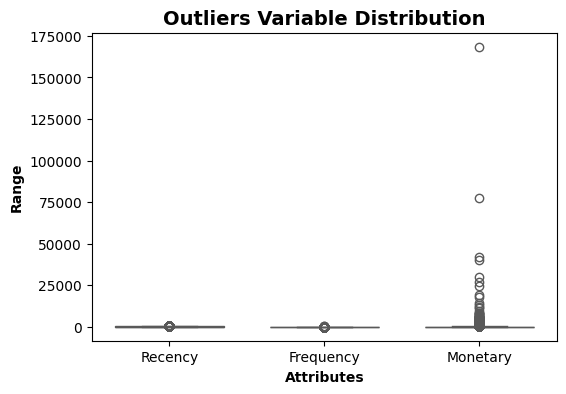

In [28]:
# Phân tích giá trị ngoại lai của recency, frequency, monetary
attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [6,4]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [29]:
# Loại bỏ các giá trị ngoại lai cho Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Loại bỏ các giá trị ngoại lai cho Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Loại bỏ các giá trị ngoại lai cho Monetary
Q1 = rfm.Monetary.quantile(0.25)
Q3 = rfm.Monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

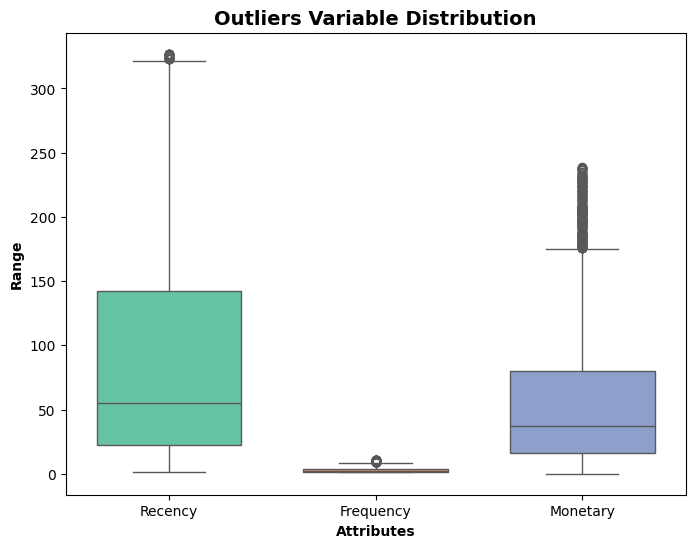

In [30]:
# Phân tích giá trị ngoại lai của recency, frequency, monetary
attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [31]:
rfm_df = rfm[['Frequency', 'Recency', 'Monetary']]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3539, 3)

In [32]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Frequency', 'Recency', 'Monetary']
rfm_df_scaled.head()

,Frequency,Recency,Monetary
0,1.948929,-0.981552,1.935755
1,-0.818647,-0.802773,-0.769124
2,-0.818647,2.459947,-0.582908
3,-0.818647,1.275535,-0.679667
4,-0.818647,1.588398,-0.663236


# **3. Thuật toán Hierarchical Clustering**

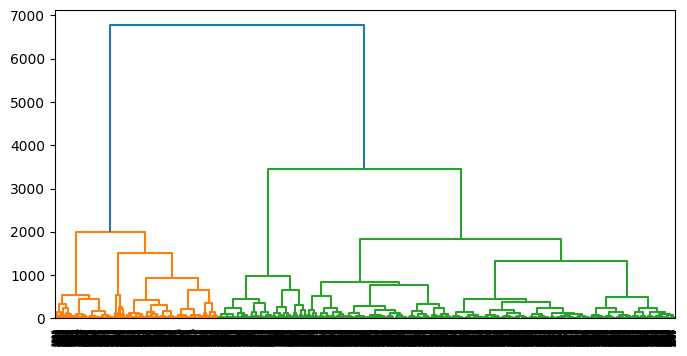

In [37]:
import scipy.cluster.hierarchy as sch
# Tính toán ma trận khoảng cách
distance_matrix = sch.linkage(rfm[['Recency', 'Frequency', 'Monetary']], method='ward')

# Vẽ dendrogram
plt.figure(figsize=(8,4))
dendrogram = sch.dendrogram(distance_matrix)
plt.show()


In [42]:
from scipy.cluster.hierarchy import fcluster

# Xác định số lượng cụm từ dendrogram (ví dụ: cắt cây tại 5 cụm)
num_clusters = 3
clusters = fcluster(distance_matrix, num_clusters, criterion='maxclust')

# Gán nhãn cụm vào DataFrame RFM
rfm['Cluster'] = clusters


In [43]:
# Xem xét trung bình của các đặc trưng trong mỗi cụm
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)


           CustomerID     Recency  Frequency    Monetary
Cluster                                                 
1        15322.204497  224.038544   1.592077   37.712173
2        15084.899408   33.262327   5.544379  161.028915
3        15343.120591   45.464252   2.632031   40.664495


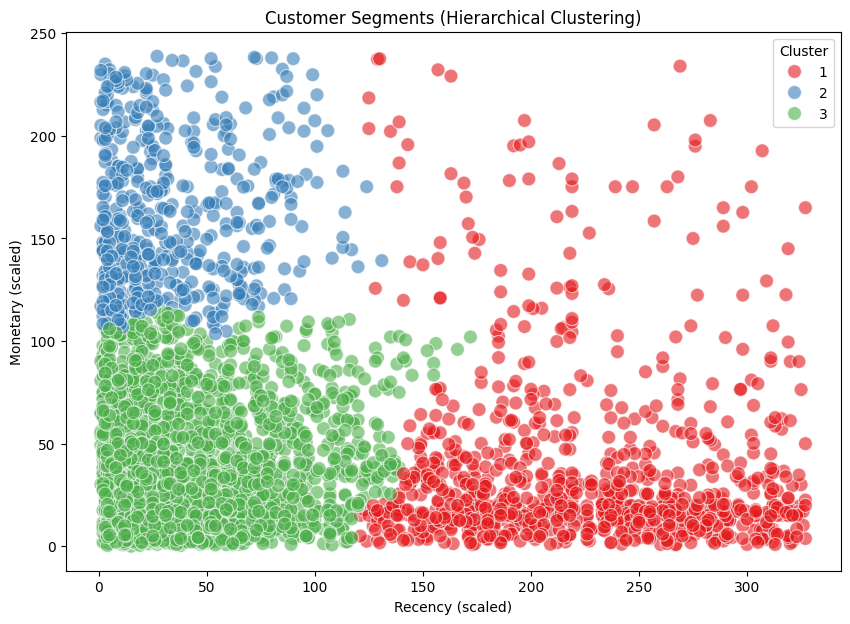

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ scatter cho các cụm
plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1', s=100, alpha=0.6, edgecolor='w')

# Tiêu đề và nhãn
plt.title('Customer Segments (Hierarchical Clustering)')
plt.xlabel('Recency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.legend(title='Cluster')
plt.show()


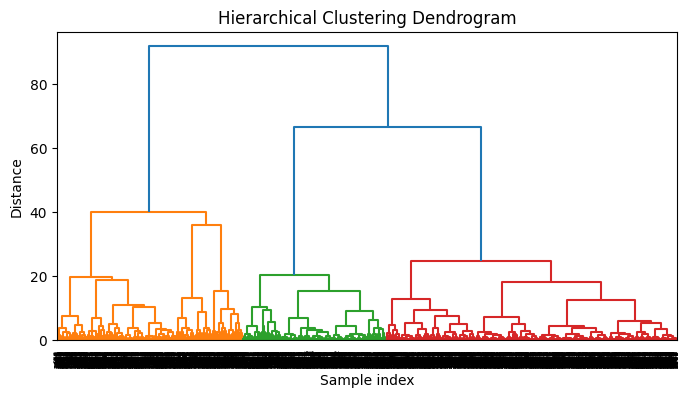

In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Tính toán liên kết sử dụng phương pháp 'ward'
Z = linkage(rfm_df_scaled, method='ward')


plt.figure(figsize=(8,4))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [67]:
from scipy.cluster.hierarchy import fcluster

# Xác định số lượng cụm từ dendrogram
num_clusters = 4
clusters = fcluster(distance_matrix, num_clusters, criterion='maxclust')

# Gán nhãn cụm vào DataFrame RFM
rfm['Cluster'] = clusters

In [68]:
# Phân tích cụm
cluster_analysis = rfm.groupby('Cluster').mean()
print(cluster_analysis)

           CustomerID     Recency  Frequency    Monetary
Cluster                                                 
1        15178.329412  283.900000   1.314706   27.919912
2        15404.557239  189.774411   1.750842   43.317172
3        15084.899408   33.262327   5.544379  161.028915
4        15343.120591   45.464252   2.632031   40.664495


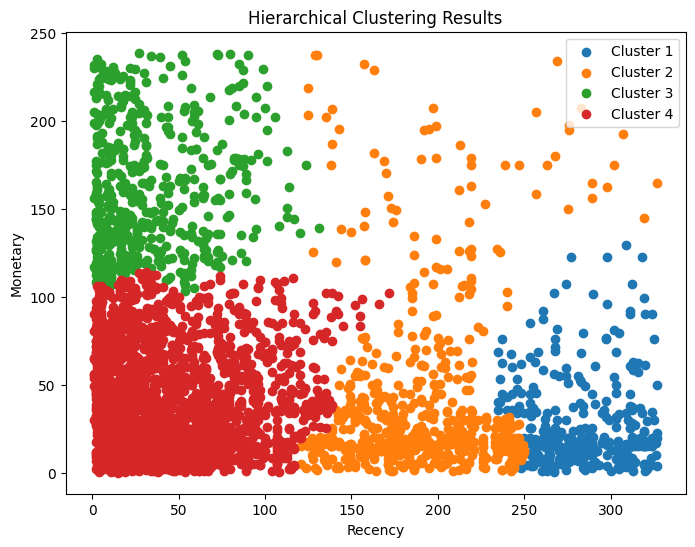

In [69]:
for cluster in set(clusters):
    clustered_data = rfm[rfm['Cluster'] == cluster]
    plt.scatter(clustered_data['Recency'], clustered_data['Monetary'], label=f'Cluster {cluster}')

plt.title('Hierarchical Clustering Results')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()
plt.show()